In [49]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas import *
from pandas_datareader import data as pdr
import tensorflow as tf
import seaborn as sns
yf.pdr_override()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [50]:
def data_load(startdate='2015-1-1', train_end='2017-12-31', test_start='2018-01-01', enddate='2018-12-31', verbose=0):
    # Tickers
    tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

    # data Close
    data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
    if verbose:
        print('\n--- Full dataset')
        display(data_close)

    # data returns
    data = data_close.shift(1) / data_close - 1
    if verbose:
        print('\n--- Full dataset returns')
        display(data)

    # Sets
    data_train = data[startdate:train_end].dropna()
    data_test = data[test_start:enddate].dropna()
    if verbose:
        print('\n--- Train set unadjusted')
        display(data_train)
        print('\n--- Test set unadjusted')
        display(data_test)

    # mu sigma train
    mu_train = data_train.mean()
    sigma_train = data_train.std()
    if verbose:
        print('\n--- mu train:')
        display(pd.DataFrame(mu_train, columns=['Train set Mean']))
        print('\n--- sigma train:')
        display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

    # Final sets
    data_train_prod = (data_train - mu_train) / sigma_train
    data_test_prod = (data_test - mu_train) / sigma_train
    if verbose:
        print('\n--- Train set adjusted')
        display(data_train_prod)
        print('\n--- Test set adjusted')
        display(data_test_prod)
    
    return data_train_prod, data_test_prod

data_train_prod, data_test_prod = data_load()

[*********************100%***********************]  8 of 8 completed


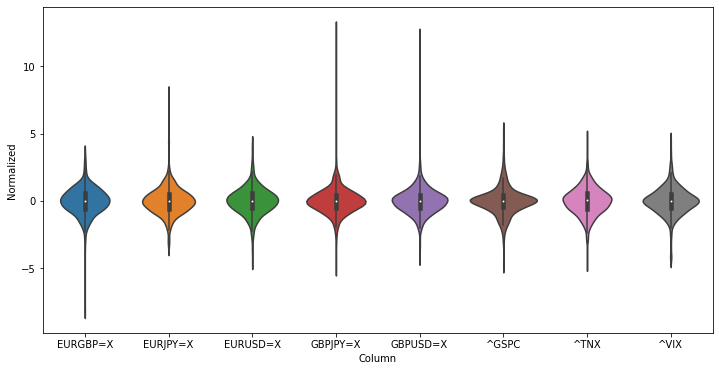

In [51]:
df_std = data_train_prod.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

In [52]:
data_train_prod.shape
data_test_prod.shape

(237, 8)

In [53]:
print(list(data_train_prod.columns))

['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', '^GSPC', '^TNX', '^VIX']


In [54]:
def evaluate_model(model, hist, inputs, labels, test_inputs, test_labels, acc=False, verbose=0):
    # Classification Logic
    if acc:
        display_columns = ['Naive (Train)', 'Naive (Test)', 'HITS (Train)', 'HITS (Val)']
        df = pd.DataFrame([], columns=display_columns)
        # Training
        pred = np.squeeze(model.predict(inputs))
        pred[pred >= 0.5] = 1
        pred[pred < 0.5] = 0
        hits = np.sum(pred == labels)/len(labels)
        naive_hits = np.sum(labels[1:] == labels[:-1])/(len(labels-1))
        
        # Validation
        pred_test = np.squeeze(model.predict(test_inputs))
        pred_test[pred_test >= 0.5] = 1
        pred_test[pred_test < 0.5] = 0
        test_hits = np.sum(pred_test == test_labels)/len(test_labels)
        naive_hits_test = np.sum(test_labels[1:] == test_labels[:-1])/(len(test_labels-1))
        
        df = df.append({key: val for key,val in zip(display_columns, 
                                                    [naive_hits, 
                                                     naive_hits_test, 
                                                     hits, 
                                                     test_hits])},
                      ignore_index=True)        
        
        #print(f'train hits: {hits} \n Test hits: {test_hits}')
        
    # Regression Logic
    else:
        display_columns = ['Naive (Train)', 'Naive (Test)', 'MASE (Train)', 'MASE (Val)']
        df = pd.DataFrame([], columns=display_columns)
        # Training
        naive_mae = mean_absolute_error(labels[1:], labels[:-1])
        std_mae = np.std(np.abs(np.squeeze(model.predict(inputs)) - labels))
        model_mae = mean_absolute_error(np.squeeze(model.predict(inputs)), labels) 
        mase = model_mae/naive_mae
        mase_std = std_mae/naive_mae
        #print('train', naive_mae, model_mae, std_mae, naive_mae, model_mae/naive_mae)
        
        # Validation
        naive_mae_test = mean_absolute_error(test_labels[1:], test_labels[:-1])
        std_mae_test = np.std(np.abs(np.squeeze(model.predict(test_inputs)) - test_labels))
        model_mae_test = mean_absolute_error(np.squeeze(model.predict(test_inputs)), test_labels)
        mase_test = model_mae_test/naive_mae_test
        mase_std_test = std_mae_test/naive_mae_test
        #print('test', model_mae_test, std_mae_test, naive_mae_test, mase_test)
        
        df = df.append({key: val for key,val in zip(display_columns, 
                                                    [naive_mae, naive_mae_test, 
                                                     f'{mase:0.2f} ({mase_std:0.2f})', 
                                                     f'{mase_test:0.2f} ({mase_std_test:0.2f})'])},
                      ignore_index=True)
    plt.figure()
    if verbose:
        plt.scatter(np.squeeze(model.predict(inputs)), labels)
        plt.title('training')
        plt.xlabel('prediction')
        plt.subplots()
        plt.scatter(np.squeeze(model.predict(test_inputs)), test_labels)
        plt.title('testing')
        plt.xlabel('prediction')
    pd.DataFrame(hist.history).plot()
    plt.show()
    return df

In [55]:
def window_data(data, window_size):
    last_index = len(data)-window_size
    
    trunc_data = [data[i:i+window_size] for i in range(last_index)]
    return np.dstack(trunc_data)
    
def gen_data(train, window, val, col=0, cls=False):
    val_data = train[-window:].append(val).values
    inputs = np.transpose(window_data(train.values, window), (2,0,1))
    labels = train.values[window:,col]
    val_inputs = np.transpose(window_data(val_data, window), (2,0,1))
    val_labels = val_data[window:,col]
    
    if cls==True:
        labels = labels > 0
        val_labels = val_labels > 0
        labels = labels.astype(int)
        val_labels = val_labels.astype(int)
    return (inputs,labels), (val_inputs, val_labels)

In [56]:
def run_wrapper(model, window, train, test, loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(1e-3), cls=False, truth_idx=0, verbose=0, epochs=50):
    tf.random.set_seed(1234)
    # if cls = True, runs HITS instead of MAE
    model.compile(loss=loss, optimizer=optimizer)
    if verbose:
        model.summary()
    
    train, val = gen_data(train, window, test, cls=cls, col=truth_idx)
    hist = model.fit(*train, epochs=epochs, verbose=0, validation_data=val)
    data = evaluate_model(model, hist, *train, *val, acc=cls)
    return data

In [57]:
def yearly_rolling_wrapper(build_model, window, start_year, end_year, cols, loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(1e-3), cls=False, truth_idx=0, verbose=0, epochs=50):
    year_first = '-01-01'
    year_last = '-12-31'
    all_data = pd.DataFrame([])
    for i in range(end_year-start_year+1):
        tf.random.set_seed(1234)
        model = build_model()
        d1 = str(start_year + i) + year_first
        d2 = str(start_year + 2 + i) + year_last
        d3 = str(start_year + 3 + i) + year_first
        d4 = str(start_year + 3 + i) + year_last
        print(d1, d2, d3, d4)
        data_train, data_test = data_load(d1, d2, d3, d4)
        train = data_train.loc[:, cols]
        test = data_test.loc[:, cols]
        data = run_wrapper(model, window, train, test, loss, optimizer, cls, truth_idx, verbose, epochs)
        all_data = all_data.append(data, ignore_index=True)
    return all_data

## Index Forecasting (Conditional)

In [58]:
num_features=3
num_timesteps=1
lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

In [59]:
idx_train = data_train_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]
idx_test = data_test_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10)                560       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

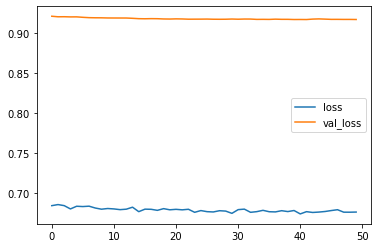

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.004346,1.247216,0.67 (0.72),0.73 (0.76)


In [60]:
window=1
lstm_model_1_data = run_wrapper(lstm_model_1, window, idx_train, idx_test, verbose=1)
lstm_model_1_data

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10)                560       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

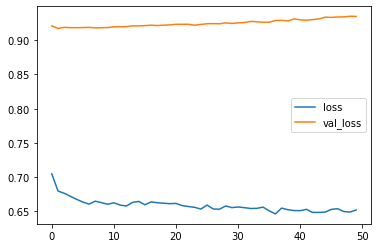

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.993952,1.247216,0.64 (0.71),0.75 (0.78)


In [61]:
window=16
lstm_model_16_data = run_wrapper(lstm_model_16, window, idx_train, idx_test, verbose=1)
lstm_model_16_data

In [ ]:
window=256
lstm_model_256_data = run_wrapper(lstm_model_256, window, idx_train, idx_test, verbose=1)
lstm_model_256_data

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                560       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


## Index Forecasting (Unconditional)

## Index Forecasting Classification (Conditional)

In [ ]:
num_features=3
num_timesteps=1
class_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

num_timesteps=16
class_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

num_timesteps=256
class_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
window=1
class_lstm_model_1_data = run_wrapper(class_lstm_model_1, window, idx_train, idx_test, cls=True)
class_lstm_model_1_data

In [ ]:
window=16
class_lstm_model_16_data = run_wrapper(class_lstm_model_16, window, idx_train, idx_test, cls=True)
class_lstm_model_16_data

In [ ]:
window=256
class_lstm_model_256_data = run_wrapper(class_lstm_model_256, window, idx_train, idx_test, cls=True)
class_lstm_model_256_data

## Index Forecasting Classification (Unconditional)

## Exchange Rate Forecasting (Conditional)

In [ ]:
num_features=5
num_timesteps=1
er_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
er_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
er_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
er_columns = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_train = data_train_prod.loc[:, er_columns]
er_test = data_test_prod.loc[:, er_columns]

In [ ]:
er_test.diff().abs().mean()

In [ ]:
window=1
er_lstm_model_1_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_1, window, er_train, er_test, truth_idx=i)
    er_lstm_model_1_data = er_lstm_model_1_data.append(data)
    
er_lstm_model_1_data.index = [er_columns[i] for i in range(5)]

In [ ]:
er_lstm_model_1_data

In [ ]:
window=16
er_lstm_model_16_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_16, window, er_train, er_test, truth_idx=i)
    er_lstm_model_16_data = er_lstm_model_16_data.append(data)
    
er_lstm_model_16_data.index = [er_columns[i] for i in range(5)]


In [ ]:
er_lstm_model_16_data

In [ ]:
window=256
er_lstm_model_256_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_256, window, er_train, er_test, truth_idx=i)
    er_lstm_model_256_data = er_lstm_model_256_data.append(data)
    
er_lstm_model_256_data.index = [er_columns[i] for i in range(5)]


In [ ]:
er_lstm_model_256_data

## Experimentation

### S&P Regression

In [ ]:
def sp_regress_16():
    num_timesteps=16
    num_features=3
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_timesteps, num_features)),
        tf.keras.layers.LSTM(5, kernel_regularizer=tf.keras.regularizers.l1(0.001), return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(5, kernel_regularizer=tf.keras.regularizers.l1(0.001), return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1)
    ])
    return model

lstm_model_16_add_layers = sp_regress_16()

window=16
lstm_model_16_add_layers_data = run_wrapper(lstm_model_16_add_layers, window, idx_train, idx_test, verbose=1, epochs=40)
lstm_model_16_add_layers_data

In [ ]:
# Original data
lstm_model_16_data

1. Three layers has higher starting validation error but converges to same point
2. Increasing dropout has smoother validation loss function but converges to same loss
3. Changing to l1 regularization speeds up training significantly
4. Changing loss function to MSE worsens performance
5. Increasing number of LSTM cells from 10 - 25 does not change performance
6. SGD, adagrad optimizers did not converge.

Overall, it seems like this is as much information as can be captured in the data, as the differences from changing hyperparameters or network architecture are small

### More Date Ranges

In [ ]:
window=16
cols = ['^GSPC', '^TNX', '^VIX']
start_time = time.time()
lstm_model_16_rolling_data = yearly_rolling_wrapper(sp_regress_16, window, 2009, 2016, cols, verbose=0, epochs=40)
print(f'Training Time = {time.time()-start_time}')
lstm_model_16_rolling_data

In [ ]:
lstm_model_16_rolling_data = lstm_model_16_rolling_data.append(lstm_model_16_rolling_data.mean(), 'Mean')
lstm_model_16_rolling_data = lstm_model_16_rolling_data.append(lstm_model_16_rolling_data.std(), 'Std')
lstm_model_16_rolling_data.index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
lstm_model_16_rolling_data.columns = ['Naive(Train)', 'Naive(Val)', 'MASE-Train(Std)', 'MASE-Val(Std)']
lstm_model_16_rolling_data.round(3)

In [ ]:
temp = lstm_model_16_rolling_data.iloc[:-2, 2:]
for col in temp:
    data = temp[col].values
    m = np.mean([float(d[:5]) for d in data])
    std = np.std([float(d[:5]) for d in data])
    lstm_model_16_rolling_data.loc['Mean', col] = np.round(m, 3)
    lstm_model_16_rolling_data.loc['Std', col] = np.round(std, 3)

lstm_model_16_rolling_data.round(3)
    

In [ ]:
lstm_model_16_rolling_data.index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
lstm_model_16_rolling_data.round(3)

### S&P Classification

In [ ]:
import time

In [ ]:
test1 = time.time()


In [ ]:
test2 = time.time()-test1
print(test2)

In [ ]:
# Original Data
# class_lstm_model_16 = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(num_timesteps, num_features)),
#     tf.keras.layers.LSTM(25, return_sequences=False),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(units=1, activation='sigmoid')
# ])
class_lstm_model_16_data

In [ ]:
def build_class_16():
    num_timesteps=16
    num_features=3
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_timesteps, num_features)),
        tf.keras.layers.LSTM(5, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(5, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(25, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    return model

class_lstm_model_16_add_layers = build_class_16()
window=16
class_lstm_model_16_data_add_layers = run_wrapper(class_lstm_model_16_add_layers, window, 
                                           idx_train, idx_test,
                                            optimizer=tf.keras.optimizers.Adam(1e-4),
                                            loss=tf.keras.losses.BinaryCrossentropy(),
                                            epochs=150,
                                           cls=True)
class_lstm_model_16_data_add_layers 

1. Lowering learning rate to 1e-4 showed better loss behavior, however worse HITS, perhaps MAE not best loss function for this task.
2. Changing loss to BinaryCrossEntropy(), Mean Squared Error, shows overfitting, poor performance
3. Adding Regularization (Dropout- , l2-regularization). l1-regularization significantly improved loss and performance.
4. Lowering number of LSTM cells improved performance
5. Additional layers X performance
3. Testing "best" architecture for regression seems to have poorer performance

In [ ]:
window=16
cols = ['^GSPC', '^TNX', '^VIX']
start_time = time.time()
class_lstm_model_16_rolling_data = yearly_rolling_wrapper(build_class_16, 
                                                          window, 2009, 2016, cols, 
                                                          optimizer=tf.keras.optimizers.Adam(1e-4), 
                                                          loss=tf.keras.losses.BinaryCrossentropy(), 
                                                          verbose=0, epochs=150, cls=True)
print(f'Training Time = {time.time()-start_time}')
class_lstm_model_16_rolling_data

In [ ]:
class_lstm_model_16_rolling_data = class_lstm_model_16_rolling_data.append(class_lstm_model_16_rolling_data.mean(), 'Mean')
class_lstm_model_16_rolling_data = class_lstm_model_16_rolling_data.append(class_lstm_model_16_rolling_data.std(), 'Std')
class_lstm_model_16_rolling_data.index = [2012 +
                                          i for i in range(8)] + ['Mean'] + ['Std']

In [ ]:
class_lstm_model_16_add_layers.summary()

In [ ]:
class_lstm_model_16_rolling_data.columns = ['Naive(Train)', 'Naive(Val)', 'HITS(Train)', 'HITS(Val)']
class_lstm_model_16_rolling_data.round(3)

## Exchange Rate Regression

1. l1 regularization improved performance
2. 
3. 
4. 
5. 

In [ ]:
def build_er_model():
    num_timesteps=16
    num_features=5
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_timesteps, num_features)),
        tf.keras.layers.LSTM(25, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(25, kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1)
    ])
    return model

window=16
er_lstm_model_16_data_ex = pd.DataFrame([])
num_to_plot = 5
for i in range(num_to_plot):
    print(er_columns[i])
    er_lstm_model_16_ex = build_er_model()
    data = run_wrapper(er_lstm_model_16_ex, window, er_train, er_test, truth_idx=i,
                      optimizer=tf.keras.optimizers.Adam(1e-3), epochs=40)
    er_lstm_model_16_data_ex = er_lstm_model_16_data_ex.append(data)
    
er_lstm_model_16_data_ex.index = [er_columns[i] for i in range(num_to_plot)]
er_lstm_model_16_data_ex


In [ ]:
# Saved Model
# er_lstm_model_16_ex = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(num_timesteps, num_features)),
#     tf.keras.layers.LSTM(10, 
#                          kernel_regularizer=tf.keras.regularizers.l2(.001), 
#                          return_sequences=True),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.LSTM(15, kernel_regularizer=tf.keras.regularizers.l2(.001), 
#                          return_sequences=False),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=1)
# ])
er_lstm_model_16_ex.summary()

In [ ]:
er_lstm_model_16_data_ex

In [ ]:
start_time = time.time()
window=16
cols = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_data = {}
for i in range(5):
    print(er_columns[i])
    er_lstm_model_16_rolling_data = yearly_rolling_wrapper(build_er_model, window, 
                                                           2009, 2016, cols, 
                                                           optimizer=tf.keras.optimizers.Adam(1e-3),  
                                                           verbose=0, epochs=50, truth_idx=i)
    er_data[er_columns[i]] = er_lstm_model_16_rolling_data
print(f'Training Time = {time.time()-start_time}')
    
for col in cols:
    display(er_data[col])
    

In [ ]:
len(er_data[cols[0]])

In [ ]:
for col in cols:
    print(col)
    if len(er_data[col]) == 8:
        er_data[col] = er_data[col].append(er_data[col].mean(), 'Mean')
        er_data[col] = er_data[col].append(er_data[col].std(), 'Std')
    er_data[col].index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
    er_data[col].columns = ['Naive(Train)', 'Naive(Val)', 'MASE-Train(Std)', 'MASE-Val(Std)']
    temp = er_data[col].iloc[:-2, 2:]
    for c in temp:
        data = temp[c].values
        m = np.mean([float(d[:5]) for d in data])
        std = np.std([float(d[:5]) for d in data])
        er_data[col].loc['Mean', c] = np.round(m, 2)
        er_data[col].loc['Std', c] = np.round(std, 2)
    

    display(er_data[col].round(2))


In [ ]:
for col in cols:
    print(col)
    display(er_data[col].round(2))